<a href="https://colab.research.google.com/github/yejikwon7/AI/blob/main/Autoencoder_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [11]:
batch_size = 256
learning_rate = 0.0002
num_epoch = 10

In [12]:
mnist_train = dset.MNIST("./", train=True, transform=transforms.ToTensor(), target_transform=None, download=True) # target_transform: 정답 label 지정X
mnist_test = dset.MNIST("./", train=False, transform=transforms.ToTensor(), target_transform=None, download=True)

In [13]:
train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=2, drop_last=True) # batch 단위로 들어감, shuffle: 중요한 차이점, data 남으면 사용X
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=False, num_workers=2, drop_last=True)

In [14]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(16), # 내에서 실행
            nn.Conv2d(16, 32, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2, 2)
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(128, 256, 3, padding=1),
            nn.ReLU()
        )

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(batch_size, -1) # flatten: 가운데에서 진행
        return out

In [15]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.layer1 = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 3, 2, 1, 1), # stride = 2, padding = 1, outpadding = 1
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.ConvTranspose2d(128, 64, 3, 1, 1),
            nn.ReLU(),
            nn.BatchNorm2d(64)
        )

        self.layer2 = nn.Sequential(
            nn.ConvTranspose2d(64, 16, 3, 1, 1),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.ConvTranspose2d(16, 1, 3, 2, 1, 1), # stride = 2: 영상 size 키움
            # input [batch, 1, 28, 28]: input과 동일해야 loss 계산 가능
            nn.ReLU()
        )

    def forward(self, x):
        out = x.view(batch_size, 256, 7, 7) # 복원
        out = self.layer1(out)
        out = self.layer2(out)
        return out

In [16]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # gpu 사용
print(device)

encoder = Encoder().to(device)
decoder = Decoder().to(device)

# 인코더 디코더의 파라미터를 동시에 학습시키기 위해 묶는 방법
parameters = list(encoder.parameters()) + list(decoder.parameters())

loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(parameters, lr=learning_rate) # lr: step size 조절

cuda:0


In [17]:
loss_arr = [] # loss 저장
for i in range(num_epoch): # epoch 수행
    for j, [image, label] in enumerate(train_loader): # iteration 수행
        optimizer.zero_grad()

        # noise 추가
        noise = init.normal_(torch.FloatTensor(batch_size, 1, 28, 28), 0, 0.1)
        image = image + noise
        image = image.to(device)

        output = encoder(image)
        output = decoder(output)

        loss = loss_func(output, image) # 정답으로 사용하고자 하는 것 넣음
        loss.backward()
        optimizer.step()

        if j % 1000 == 0:
            print(loss)
            loss_arr.append(loss.cpu().detach().numpy())

tensor(0.5241, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0237, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0210, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0198, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0193, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0187, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0184, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0180, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0177, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0175, device='cuda:0', grad_fn=<MseLossBackward0>)


torch.Size([256, 28, 28])


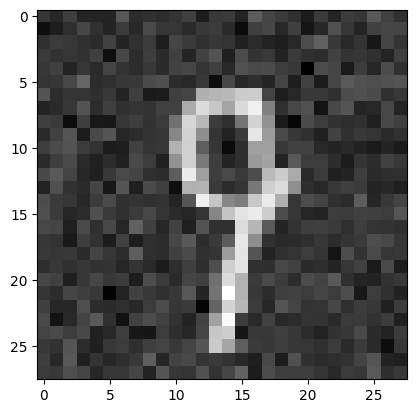

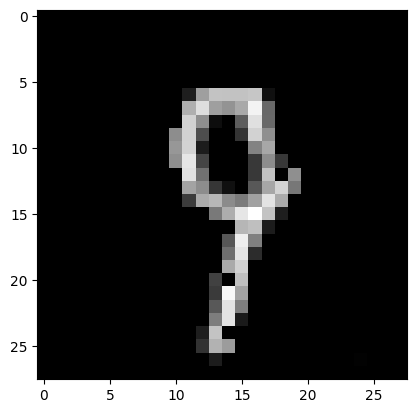

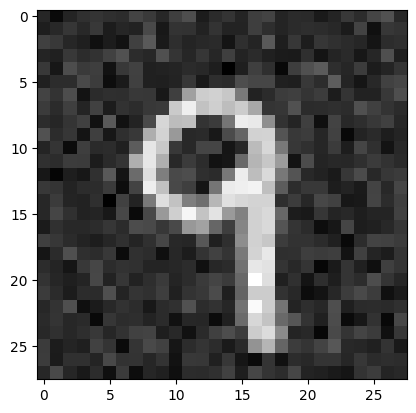

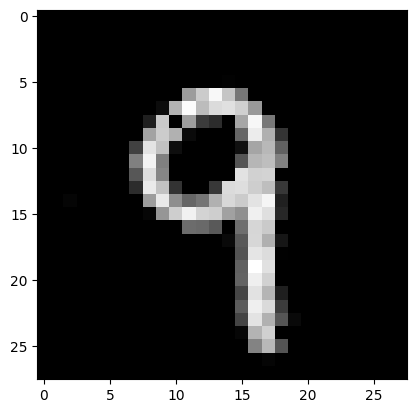

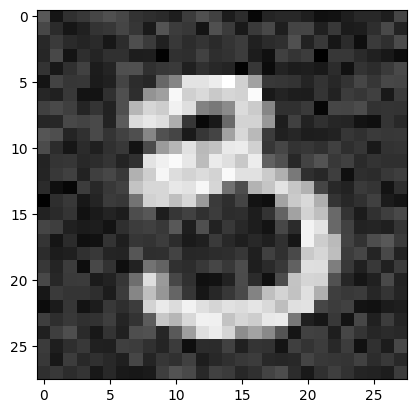

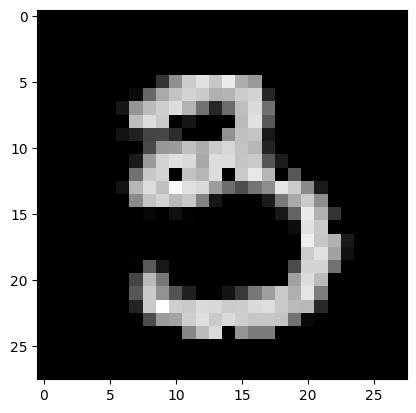

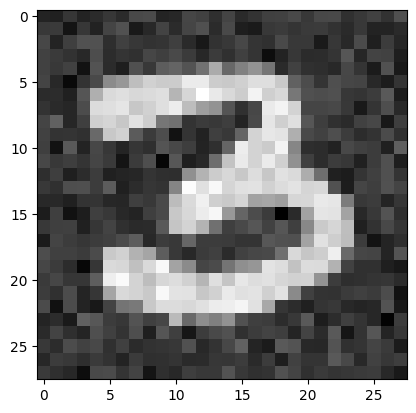

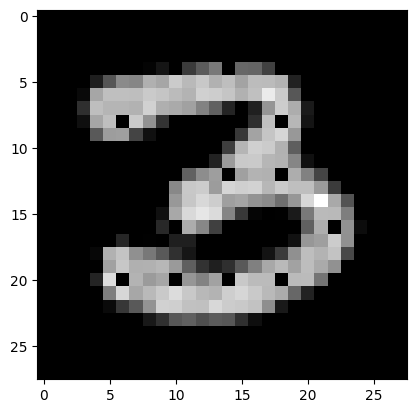

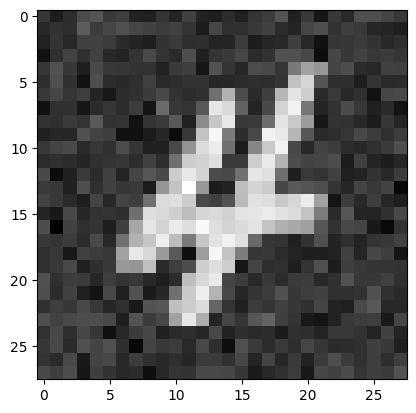

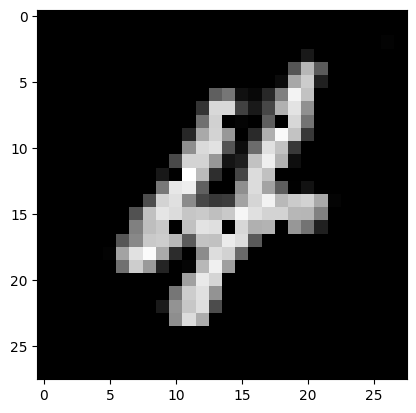

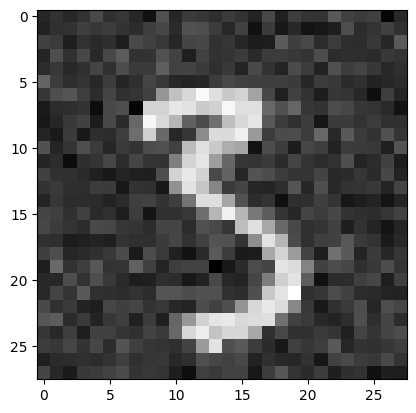

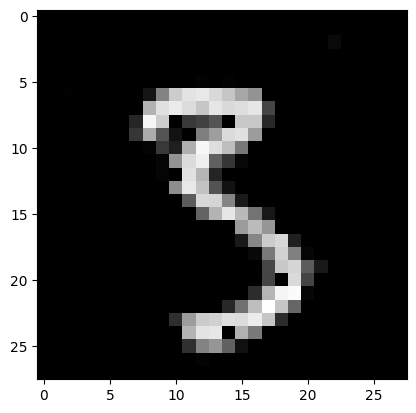

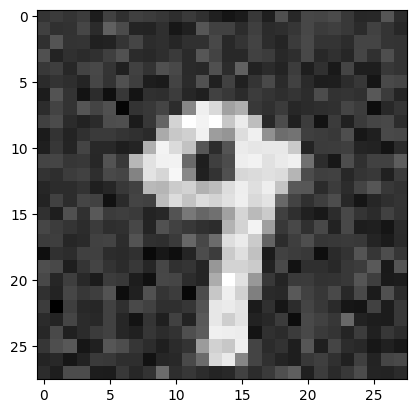

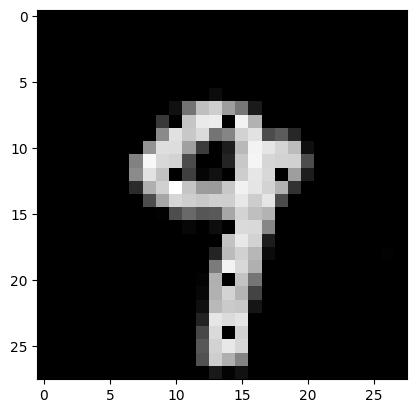

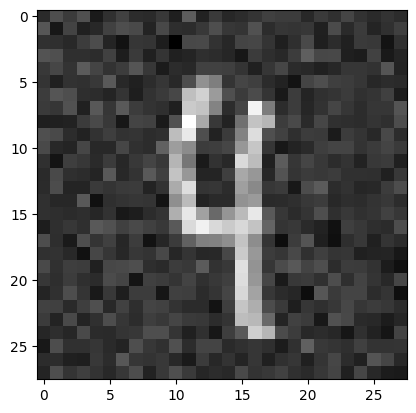

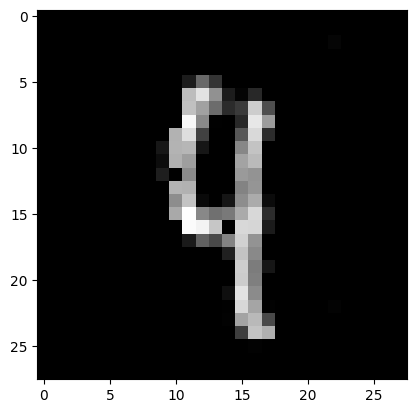

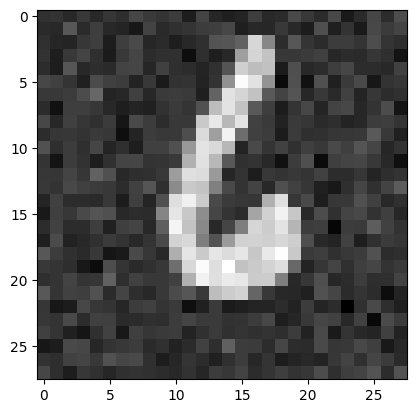

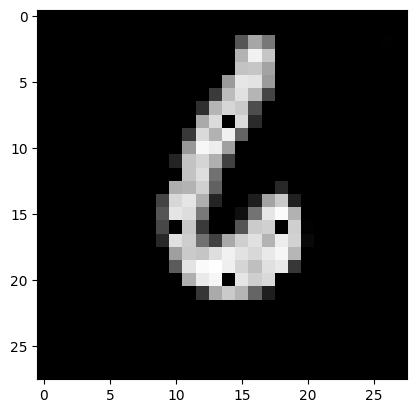

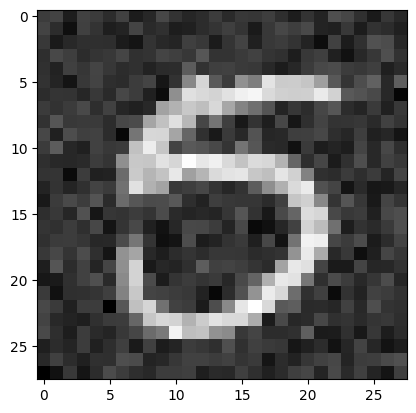

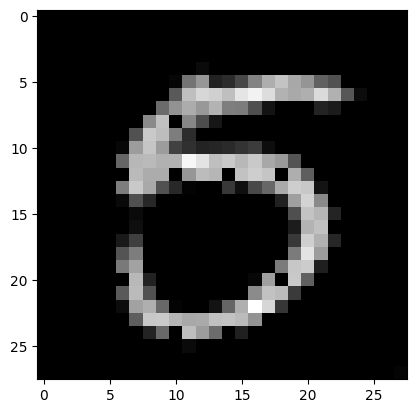

In [18]:
out_img = torch.squeeze(output.cpu().data)
print(out_img.size())

for i in range(10):
    plt.imshow(torch.squeeze(image[i]).cpu().numpy(), cmap='gray') # 실제 데이터
    plt.show()
    plt.imshow(out_img[i].numpy(), cmap='gray')
    plt.show()

In [21]:
with torch.no_grad():
    for i in range(1): # epoch 돌 필요X, 없어도 되는 코드
        for j, [image, label] in enumerate(test_loader):
            x = image.to(device)

            optimizer.zero_grad()

            # noise 추가
            noise = init.normal_(torch.FloatTensor(batch_size, 1, 28, 28), 0, 0.1)
            image = image + noise
            image = image.to(device)

            output = encoder(image)
            output = decoder(output)

        if j % 1000 == 0:
            print(loss)

torch.Size([256, 28, 28])


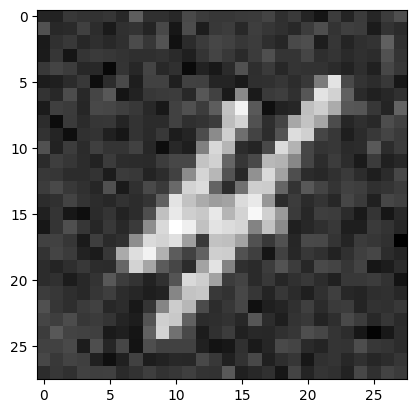

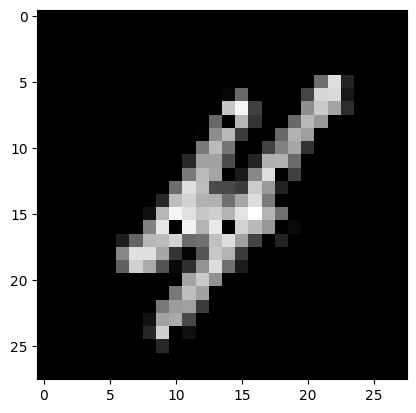

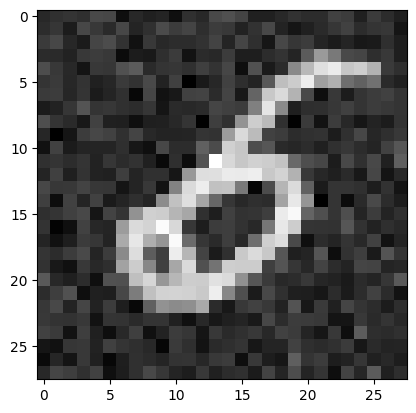

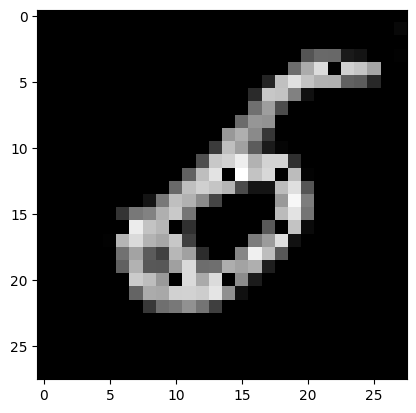

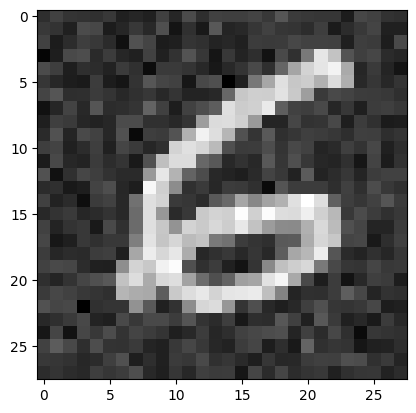

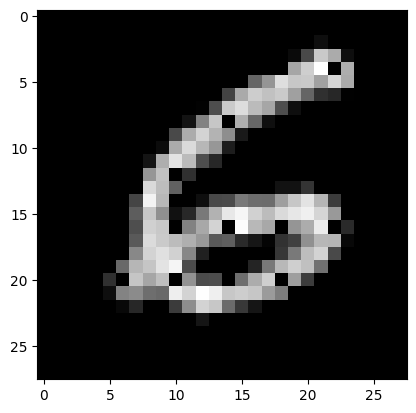

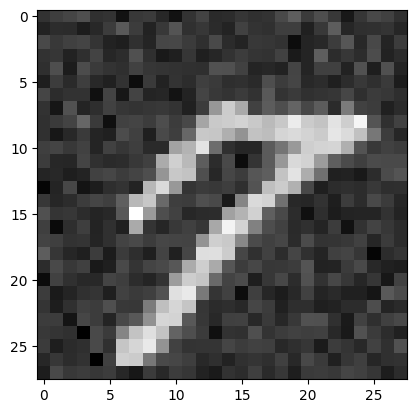

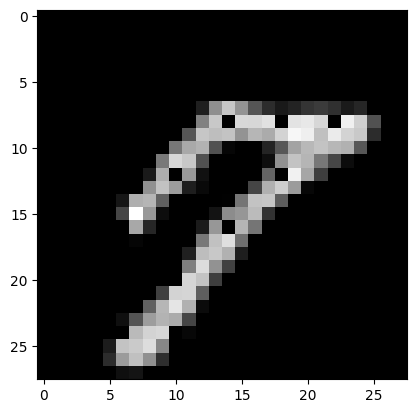

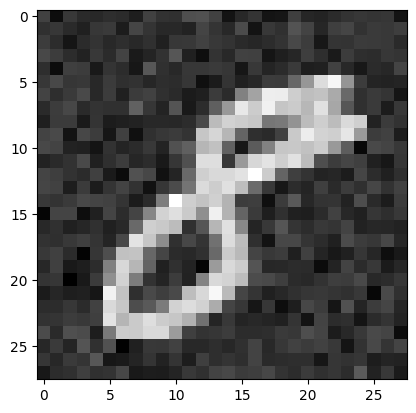

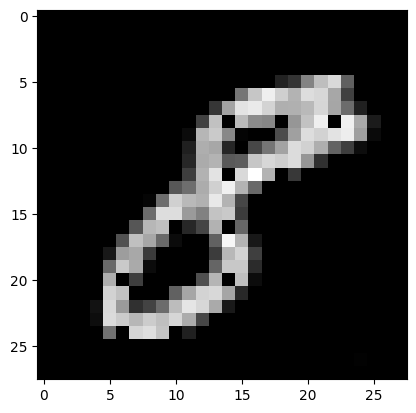

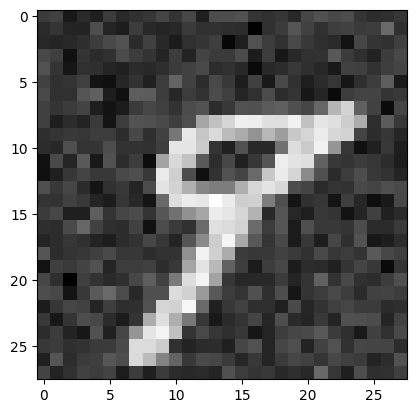

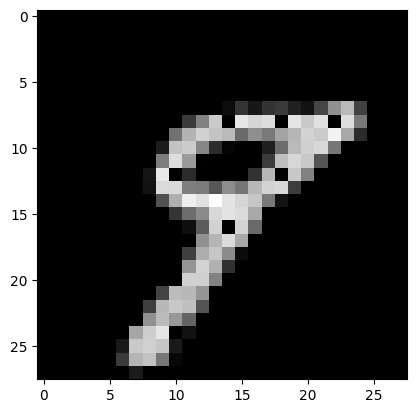

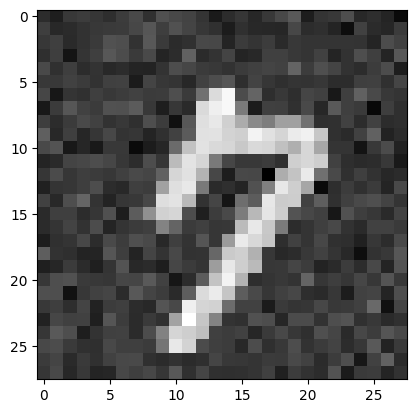

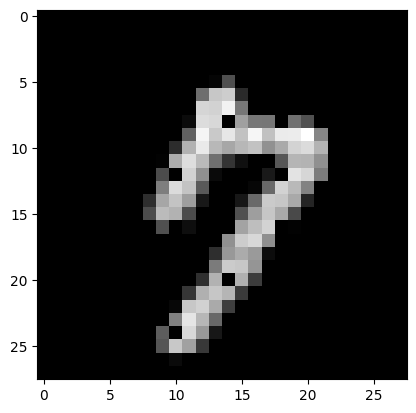

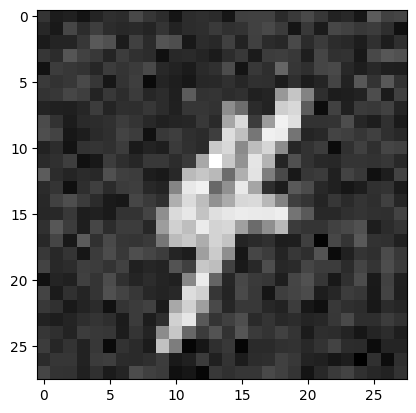

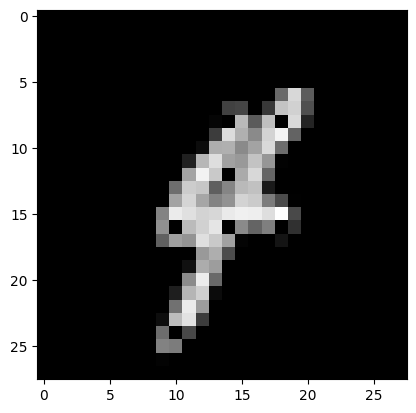

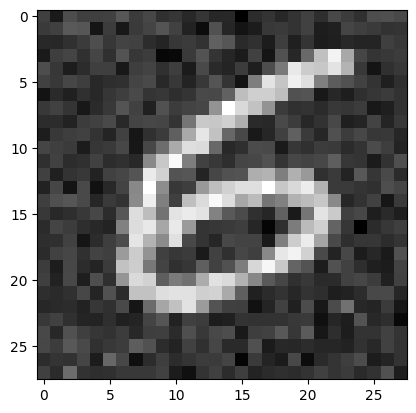

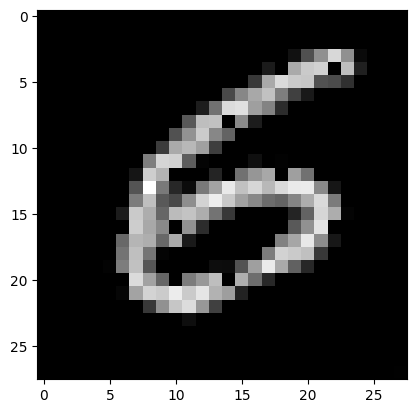

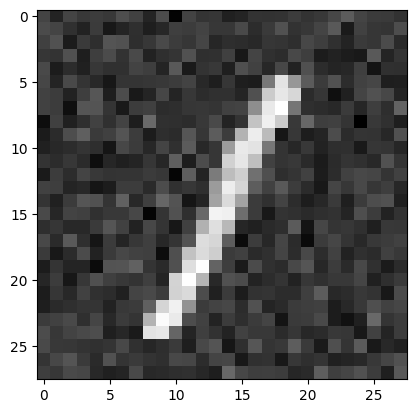

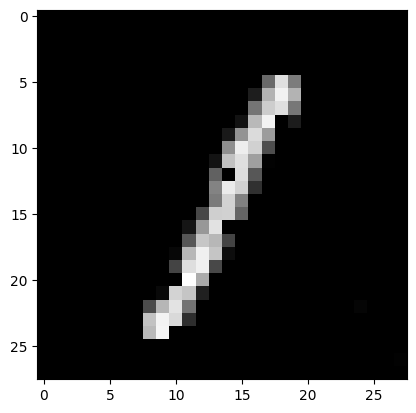

In [23]:
out_img = torch.squeeze(output.cpu().data)
print(out_img.size())

for i in range(10):
    plt.imshow(torch.squeeze(image[i]).cpu().numpy(), cmap='gray')
    plt.show()
    plt.imshow(out_img[i].numpy(), cmap='gray')
    plt.show()